In [1]:
#!pip install optuna
#!pip install plotly

In [2]:
import numpy as np 
import pandas as pd 
import pickle
from math import ceil
import functools
import gc

import seaborn as sns
import matplotlib.pyplot as plt
import plotly
plt.style.use('fivethirtyeight')


In [3]:
# Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1


In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


 
# Step 2: Hierarchical learning

---


In [5]:
#start of hierarchical learning

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
import lightgbm as lgb

In [7]:
#load prepared data

In [8]:
df = pd.read_pickle('data/interim/grid_df_gho.pkl')

In [9]:
df.head()

,id,item_id,dept_id,state_id,d,sales,event_name_1,event_type_1,event_name_2,event_type_2,...,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,CA,897,0.0,None,None,None,None,...,1,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,CA,898,0.0,None,None,None,None,...,1,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,CA,899,0.0,None,None,None,None,...,1,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,CA,900,0.0,None,None,None,None,...,1,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,CA,901,0.0,None,None,None,None,...,1,0,0,0,0,0,0,0,0,0


In [10]:
#dropping some features

In [11]:
def drop_features(dfx):
    dfx.drop(columns=['id', 
                           'item_id',
                           'event_name_1', 
                           'event_type_1', 
                           'event_name_2', 
                           'event_type_2',
                           'sales', 
                           'dept_id',
                           'state_id',], inplace=True)
    return dfx

In [12]:
df = drop_features(df)

In [13]:
df['product_share']=df['product_share']/100.

In [14]:
# TEMPORAL SPLIT 

In [15]:
df_train = df[(df['d'] < 1914-28) & (df['d'] > 800)] 
df_test = df[(df['d'] >= 1914-28) & (df['d'] < 1914)] 
df_validation = df[df['d'] >= 1914] 

In [16]:
df_train.drop(columns=['d'], inplace=True)
df_test.drop(columns=['d'], inplace=True)
df_validation.drop(columns=['d'], inplace=True)

/home/hochard/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
# Setting targets

In [18]:
y_train = df_train['product_share']
y_test = df_test['product_share']

df_train.drop(columns=['product_share'], inplace=True) 
df_test.drop(columns=['product_share'], inplace=True) 

In [19]:
len(df_train.dtypes)

27

In [20]:
dtrain = lgb.Dataset(df_train, label=y_train)
dval = lgb.Dataset(df_test, label=y_test)

In [21]:
#train tout simple pour tester 

In [22]:
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'cross_entropy'
params['metric'] = 'cross_entropy'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10


In [37]:
import time
start_time = time.time()

watchlist = [dtrain, dval]

#training lightgbm 
clf = lgb.train(params, train_set = dtrain,
                valid_sets=watchlist,
                num_boost_round=100, 
                early_stopping_rounds=20)

end_time = time.time()
print('time elapsed (seconds):', np.round(end_time-start_time))

[1]	training's cross_entropy: 0.0173074	valid_1's cross_entropy: 0.0162499
Training until validation scores don't improve for 20 rounds
[2]	training's cross_entropy: 0.0173019	valid_1's cross_entropy: 0.0162454
[3]	training's cross_entropy: 0.0172975	valid_1's cross_entropy: 0.016242
[4]	training's cross_entropy: 0.0172933	valid_1's cross_entropy: 0.0162388
[5]	training's cross_entropy: 0.017289	valid_1's cross_entropy: 0.0162355
[6]	training's cross_entropy: 0.017284	valid_1's cross_entropy: 0.0162315
[7]	training's cross_entropy: 0.0172819	valid_1's cross_entropy: 0.0162296
[8]	training's cross_entropy: 0.0172778	valid_1's cross_entropy: 0.0162264
[9]	training's cross_entropy: 0.0172756	valid_1's cross_entropy: 0.0162245
[10]	training's cross_entropy: 0.0172751	valid_1's cross_entropy: 0.016224
[11]	training's cross_entropy: 0.017271	valid_1's cross_entropy: 0.0162208
[12]	training's cross_entropy: 0.0172661	valid_1's cross_entropy: 0.0162167
[13]	training's cross_entropy: 0.0172655	

In [24]:
y_pred=clf.predict(df_test)
error = mean_squared_error(y_test, y_pred)
print('rmse error:', error)

rmse error: 4.394508995615032e-05


In [26]:
#hyper parameter tuning 

In [41]:
num_rounds = 1000

In [42]:
from optuna import Trial

def objective(trial:Trial, fastCheck=True, targetMeter=0, returnInfo=False):
    
    model, yPredValid, log = fitLGBM(trial, dtrain, dval, df_test, y_test, numRounds=num_rounds)
    gc.collect()
    validScore =log["valid xentropy"]
    
    return validScore

In [43]:
def fitLGBM(trial, dtrain, dval, df_test, y_test, numRounds=num_rounds):
    
    params = {
        "objective": "cross_entropy",
        "metric": "cross_entropy",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate" : trial.suggest_loguniform("learning_rate", 5e-7, 5e-1),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "max_bin": trial.suggest_int("max_bin", 32, 255),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 256),
        'min_data_in_bin': trial.suggest_int('min_data_in_bin', 1, 256),
        'min_gain_to_split' : trial.suggest_discrete_uniform('min_gain_to_split', 0.1, 5, 0.01),      
    }

    earlyStop=20
    verboseEval=0
    
    watchlist = [dtrain, dval]

    # Callback for pruning.
    lgbmPruningCallback = optuna.integration.LightGBMPruningCallback(trial, 'cross_entropy', valid_name='valid_1')
    
    model = lgb.train(params,
                      train_set=dtrain,
                      num_boost_round=numRounds,
                      valid_sets=watchlist,
                      verbose_eval=verboseEval,
                      early_stopping_rounds=earlyStop,
                      callbacks=[lgbmPruningCallback])
    
    #predictions
    y_pred = model.predict(df_test, num_iteration=model.best_iteration)
    
    error = mean_squared_error(y_test, y_pred)

    print('***********************RMSE error :', error)
    log={'train xentropy':model.best_score['training']['cross_entropy'],
         'valid xentropy':model.best_score['valid_1']['cross_entropy']}
    
    return model, y_pred, log

In [44]:
start_time = time.time()

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="minimize")

study.optimize(objective, n_trials=100)

end_time = time.time()
print('time elapsed (seconds):', np.round(end_time-start_time))

***********************RMSE error : 4.445704940775249e-05


[I 2020-06-01 23:07:07,636] Finished trial#0 with value: 0.01623548803451911 with parameters: {'learning_rate': 7.988904924119535e-06, 'lambda_l1': 9.332243940674252e-05, 'lambda_l2': 0.02308042163929847, 'num_leaves': 184, 'max_depth': 10, 'max_bin': 41, 'feature_fraction': 0.9008702414186154, 'bagging_fraction': 0.848215462319994, 'bagging_freq': 4, 'min_child_samples': 73, 'min_data_in_leaf': 40, 'min_data_in_bin': 243, 'min_gain_to_split': 2.42}. Best is trial#0 with value: 0.01623548803451911.


***********************RMSE error : 4.45121056309461e-05


[I 2020-06-01 23:31:47,407] Finished trial#1 with value: 0.01624648112671596 with parameters: {'learning_rate': 2.5220579182894676e-06, 'lambda_l1': 8.067898750185522e-05, 'lambda_l2': 0.003478945668621516, 'num_leaves': 91, 'max_depth': 15, 'max_bin': 209, 'feature_fraction': 0.75639724144409, 'bagging_fraction': 0.5297126163703857, 'bagging_freq': 5, 'min_child_samples': 39, 'min_data_in_leaf': 216, 'min_data_in_bin': 16, 'min_gain_to_split': 2.66}. Best is trial#0 with value: 0.01623548803451911.


***********************RMSE error : 4.181577192327654e-05


[I 2020-06-01 23:58:59,556] Finished trial#2 with value: 0.015834702682442976 with parameters: {'learning_rate': 0.00037017137519645824, 'lambda_l1': 0.00013453276478413406, 'lambda_l2': 1.6520008473207896e-06, 'num_leaves': 152, 'max_depth': 15, 'max_bin': 140, 'feature_fraction': 0.912208713680511, 'bagging_fraction': 0.5015969466131242, 'bagging_freq': 2, 'min_child_samples': 80, 'min_data_in_leaf': 249, 'min_data_in_bin': 107, 'min_gain_to_split': 4.68}. Best is trial#2 with value: 0.015834702682442976.


***********************RMSE error : 3.9050527909135094e-05


[I 2020-06-02 00:08:46,237] Finished trial#3 with value: 0.015495801247978894 with parameters: {'learning_rate': 0.014742455557264741, 'lambda_l1': 0.001023850182763574, 'lambda_l2': 8.580299063495601e-07, 'num_leaves': 77, 'max_depth': 13, 'max_bin': 153, 'feature_fraction': 0.7221075553613421, 'bagging_fraction': 0.5331392075467332, 'bagging_freq': 4, 'min_child_samples': 85, 'min_data_in_leaf': 72, 'min_data_in_bin': 47, 'min_gain_to_split': 3.48}. Best is trial#3 with value: 0.015495801247978894.


***********************RMSE error : 4.3231478045923566e-05


[I 2020-06-02 00:27:39,290] Finished trial#4 with value: 0.016028751498046393 with parameters: {'learning_rate': 0.00036927438777645266, 'lambda_l1': 0.0002753059767036483, 'lambda_l2': 0.022718306092948885, 'num_leaves': 243, 'max_depth': 2, 'max_bin': 189, 'feature_fraction': 0.6539445271489235, 'bagging_fraction': 0.9367458461341642, 'bagging_freq': 5, 'min_child_samples': 60, 'min_data_in_leaf': 9, 'min_data_in_bin': 21, 'min_gain_to_split': 0.32}. Best is trial#3 with value: 0.015495801247978894.


***********************RMSE error : 3.986862138851447e-05


[I 2020-06-02 00:28:37,883] Finished trial#5 with value: 0.015548282856623076 with parameters: {'learning_rate': 0.31861257407317917, 'lambda_l1': 2.408834614635858e-08, 'lambda_l2': 8.165484685773725e-07, 'num_leaves': 72, 'max_depth': 19, 'max_bin': 194, 'feature_fraction': 0.5029308023180911, 'bagging_fraction': 0.4200391812506534, 'bagging_freq': 5, 'min_child_samples': 51, 'min_data_in_leaf': 244, 'min_data_in_bin': 10, 'min_gain_to_split': 4.77}. Best is trial#3 with value: 0.015495801247978894.
[I 2020-06-02 00:28:49,321] Setting status of trial#6 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.8432244566661994e-05


[I 2020-06-02 00:58:15,337] Finished trial#7 with value: 0.015430696058407457 with parameters: {'learning_rate': 0.012267754648536971, 'lambda_l1': 4.746831975005726, 'lambda_l2': 5.330734006159441, 'num_leaves': 184, 'max_depth': 20, 'max_bin': 200, 'feature_fraction': 0.6374868894171288, 'bagging_fraction': 0.9038017802247659, 'bagging_freq': 5, 'min_child_samples': 33, 'min_data_in_leaf': 224, 'min_data_in_bin': 86, 'min_gain_to_split': 0.41000000000000003}. Best is trial#7 with value: 0.015430696058407457.
[I 2020-06-02 00:58:24,732] Setting status of trial#8 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 00:58:33,999] Setting status of trial#9 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.790594200288385e-05


[I 2020-06-02 01:10:55,192] Finished trial#10 with value: 0.015383979808111481 with parameters: {'learning_rate': 0.04672556449915609, 'lambda_l1': 0.19223541123883978, 'lambda_l2': 7.505821327156282, 'num_leaves': 256, 'max_depth': 20, 'max_bin': 238, 'feature_fraction': 0.5963624737736998, 'bagging_fraction': 0.985375832323254, 'bagging_freq': 7, 'min_child_samples': 6, 'min_data_in_leaf': 181, 'min_data_in_bin': 196, 'min_gain_to_split': 0.14}. Best is trial#10 with value: 0.015383979808111481.


***********************RMSE error : 3.802537933551528e-05


[I 2020-06-02 01:19:24,500] Finished trial#11 with value: 0.015395464888510147 with parameters: {'learning_rate': 0.05465751013425922, 'lambda_l1': 0.11232641580037202, 'lambda_l2': 9.874040534636881, 'num_leaves': 242, 'max_depth': 20, 'max_bin': 254, 'feature_fraction': 0.6153093991919243, 'bagging_fraction': 0.9789164130712753, 'bagging_freq': 7, 'min_child_samples': 10, 'min_data_in_leaf': 161, 'min_data_in_bin': 213, 'min_gain_to_split': 0.24000000000000002}. Best is trial#10 with value: 0.015383979808111481.


***********************RMSE error : 3.8938556361168337e-05


[I 2020-06-02 01:20:39,033] Finished trial#12 with value: 0.015463387600816078 with parameters: {'learning_rate': 0.3617065476784789, 'lambda_l1': 0.07749898008325296, 'lambda_l2': 6.059939180052031, 'num_leaves': 247, 'max_depth': 18, 'max_bin': 255, 'feature_fraction': 0.514272027225567, 'bagging_fraction': 0.9992004510497131, 'bagging_freq': 7, 'min_child_samples': 6, 'min_data_in_leaf': 181, 'min_data_in_bin': 203, 'min_gain_to_split': 1.2000000000000002}. Best is trial#10 with value: 0.015383979808111481.


***********************RMSE error : 3.873815733574562e-05


[I 2020-06-02 01:32:00,970] Finished trial#13 with value: 0.015456346889230609 with parameters: {'learning_rate': 0.022617309610826437, 'lambda_l1': 0.06607319810545503, 'lambda_l2': 0.8924609408886841, 'num_leaves': 253, 'max_depth': 9, 'max_bin': 249, 'feature_fraction': 0.5870617468054775, 'bagging_fraction': 0.7593053813137137, 'bagging_freq': 7, 'min_child_samples': 5, 'min_data_in_leaf': 157, 'min_data_in_bin': 194, 'min_gain_to_split': 1.12}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 01:34:54,310] Setting status of trial#14 as TrialState.PRUNED. Trial was pruned at iteration 122.
[I 2020-06-02 01:35:06,590] Setting status of trial#15 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 01:35:20,791] Setting status of trial#16 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.807365591641739e-05


[I 2020-06-02 01:39:05,298] Finished trial#17 with value: 0.015407887056659046 with parameters: {'learning_rate': 0.07971759503035489, 'lambda_l1': 0.5495844208807855, 'lambda_l2': 0.5701859968596182, 'num_leaves': 217, 'max_depth': 17, 'max_bin': 226, 'feature_fraction': 0.8121338133247982, 'bagging_fraction': 0.9682641107516065, 'bagging_freq': 6, 'min_child_samples': 24, 'min_data_in_leaf': 200, 'min_data_in_bin': 237, 'min_gain_to_split': 0.75}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 01:39:22,138] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.846295273836005e-05


[I 2020-06-02 01:40:45,459] Finished trial#19 with value: 0.01550235238160056 with parameters: {'learning_rate': 0.4663441303478698, 'lambda_l1': 0.005355064390960959, 'lambda_l2': 0.04609261023977546, 'num_leaves': 255, 'max_depth': 12, 'max_bin': 164, 'feature_fraction': 0.9869988475421183, 'bagging_fraction': 0.8019932454579767, 'bagging_freq': 7, 'min_child_samples': 32, 'min_data_in_leaf': 113, 'min_data_in_bin': 153, 'min_gain_to_split': 0.1}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 01:43:12,945] Setting status of trial#20 as TrialState.PRUNED. Trial was pruned at iteration 114.


***********************RMSE error : 3.8109798366746e-05


[I 2020-06-02 01:47:57,360] Finished trial#21 with value: 0.015407976129835079 with parameters: {'learning_rate': 0.06634469800308233, 'lambda_l1': 0.7918075335443765, 'lambda_l2': 0.7102774577836031, 'num_leaves': 219, 'max_depth': 17, 'max_bin': 220, 'feature_fraction': 0.8159751409987478, 'bagging_fraction': 0.973960568042915, 'bagging_freq': 6, 'min_child_samples': 24, 'min_data_in_leaf': 202, 'min_data_in_bin': 238, 'min_gain_to_split': 0.72}. Best is trial#10 with value: 0.015383979808111481.


***********************RMSE error : 3.833070143639715e-05


[I 2020-06-02 01:57:53,348] Finished trial#22 with value: 0.015420443697624681 with parameters: {'learning_rate': 0.03510238593928628, 'lambda_l1': 0.5897635095285348, 'lambda_l2': 9.607652425168133, 'num_leaves': 228, 'max_depth': 20, 'max_bin': 233, 'feature_fraction': 0.6992739704581483, 'bagging_fraction': 0.9242042451719761, 'bagging_freq': 7, 'min_child_samples': 10, 'min_data_in_leaf': 202, 'min_data_in_bin': 180, 'min_gain_to_split': 0.69}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 01:58:10,093] Setting status of trial#23 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.882190643841149e-05


[I 2020-06-02 01:59:36,517] Finished trial#24 with value: 0.015459297128262968 with parameters: {'learning_rate': 0.21529827279847671, 'lambda_l1': 0.365506743238857, 'lambda_l2': 1.8261972917339315, 'num_leaves': 168, 'max_depth': 16, 'max_bin': 217, 'feature_fraction': 0.7208217094869586, 'bagging_fraction': 0.8608943078290621, 'bagging_freq': 7, 'min_child_samples': 42, 'min_data_in_leaf': 232, 'min_data_in_bin': 254, 'min_gain_to_split': 1.6700000000000002}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 01:59:51,493] Setting status of trial#25 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.857081497903538e-05


[I 2020-06-02 02:02:42,051] Finished trial#26 with value: 0.015431479710881798 with parameters: {'learning_rate': 0.13467531468079033, 'lambda_l1': 0.0011517467518581783, 'lambda_l2': 2.3014012229398686, 'num_leaves': 256, 'max_depth': 18, 'max_bin': 172, 'feature_fraction': 0.5466874619435877, 'bagging_fraction': 0.9518359992833421, 'bagging_freq': 7, 'min_child_samples': 12, 'min_data_in_leaf': 142, 'min_data_in_bin': 148, 'min_gain_to_split': 0.89}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:02:57,428] Setting status of trial#27 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.781760417261153e-05


[I 2020-06-02 02:10:12,189] Finished trial#28 with value: 0.015389292527430877 with parameters: {'learning_rate': 0.0457241981893922, 'lambda_l1': 0.01994549380938392, 'lambda_l2': 0.008294212483226732, 'num_leaves': 238, 'max_depth': 20, 'max_bin': 255, 'feature_fraction': 0.686441383985279, 'bagging_fraction': 0.8942264179636222, 'bagging_freq': 7, 'min_child_samples': 38, 'min_data_in_leaf': 122, 'min_data_in_bin': 193, 'min_gain_to_split': 0.41000000000000003}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:10:34,692] Setting status of trial#29 as TrialState.PRUNED. Trial was pruned at iteration 9.
[I 2020-06-02 02:10:50,437] Setting status of trial#30 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:11:08,113] Setting status of trial#31 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.832394767426361e-05


[I 2020-06-02 02:14:01,121] Finished trial#32 with value: 0.015418958967817498 with parameters: {'learning_rate': 0.1556553665897034, 'lambda_l1': 1.415588693486073, 'lambda_l2': 2.193052244337545, 'num_leaves': 240, 'max_depth': 18, 'max_bin': 252, 'feature_fraction': 0.6036099817976659, 'bagging_fraction': 0.9552099326000861, 'bagging_freq': 6, 'min_child_samples': 44, 'min_data_in_leaf': 93, 'min_data_in_bin': 223, 'min_gain_to_split': 0.53}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:14:17,480] Setting status of trial#33 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:14:33,765] Setting status of trial#34 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:14:55,029] Setting status of trial#35 as TrialState.PRUNED. Trial was pruned at iteration 8.
[I 2020-06-02 02:15:10,689] Setting status of trial#36 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.798750961780266e-05


[I 2020-06-02 02:16:58,431] Finished trial#37 with value: 0.015403411678898023 with parameters: {'learning_rate': 0.21114305396718394, 'lambda_l1': 1.187702448122071, 'lambda_l2': 0.006498386998032238, 'num_leaves': 242, 'max_depth': 20, 'max_bin': 207, 'feature_fraction': 0.731914464956665, 'bagging_fraction': 0.9379927031218722, 'bagging_freq': 5, 'min_child_samples': 9, 'min_data_in_leaf': 236, 'min_data_in_bin': 230, 'min_gain_to_split': 0.45000000000000007}. Best is trial#10 with value: 0.015383979808111481.


***********************RMSE error : 4.1505911648481894e-05


[I 2020-06-02 02:18:15,902] Finished trial#38 with value: 0.015488495520535285 with parameters: {'learning_rate': 0.4729922606921974, 'lambda_l1': 0.0002786347797482512, 'lambda_l2': 0.007384653269999145, 'num_leaves': 124, 'max_depth': 19, 'max_bin': 140, 'feature_fraction': 0.724752846232954, 'bagging_fraction': 0.9306545202031414, 'bagging_freq': 3, 'min_child_samples': 5, 'min_data_in_leaf': 41, 'min_data_in_bin': 186, 'min_gain_to_split': 0.45000000000000007}. Best is trial#10 with value: 0.015383979808111481.


***********************RMSE error : 3.930298033337437e-05


[I 2020-06-02 02:19:21,380] Finished trial#39 with value: 0.015490786674630578 with parameters: {'learning_rate': 0.24735281602427597, 'lambda_l1': 5.012717813086712, 'lambda_l2': 8.840026091043762e-05, 'num_leaves': 256, 'max_depth': 20, 'max_bin': 203, 'feature_fraction': 0.6142533444446687, 'bagging_fraction': 0.6580678739105695, 'bagging_freq': 4, 'min_child_samples': 83, 'min_data_in_leaf': 223, 'min_data_in_bin': 224, 'min_gain_to_split': 1.4600000000000002}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:19:37,682] Setting status of trial#40 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.815495058332818e-05


[I 2020-06-02 02:21:57,092] Finished trial#41 with value: 0.015408863182774669 with parameters: {'learning_rate': 0.12725032095450362, 'lambda_l1': 0.1861371342602372, 'lambda_l2': 0.041174362010410866, 'num_leaves': 222, 'max_depth': 20, 'max_bin': 235, 'feature_fraction': 0.8188571865109217, 'bagging_fraction': 0.9677230548819022, 'bagging_freq': 5, 'min_child_samples': 20, 'min_data_in_leaf': 196, 'min_data_in_bin': 246, 'min_gain_to_split': 0.9}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:22:14,486] Setting status of trial#42 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.795492657857734e-05


[I 2020-06-02 02:25:43,481] Finished trial#43 with value: 0.01539624745365669 with parameters: {'learning_rate': 0.08507898951507449, 'lambda_l1': 0.0399269792176962, 'lambda_l2': 0.7372242161925592, 'num_leaves': 208, 'max_depth': 19, 'max_bin': 196, 'feature_fraction': 0.8719199124129706, 'bagging_fraction': 0.8826745305053596, 'bagging_freq': 5, 'min_child_samples': 47, 'min_data_in_leaf': 173, 'min_data_in_bin': 221, 'min_gain_to_split': 0.5700000000000001}. Best is trial#10 with value: 0.015383979808111481.


***********************RMSE error : 3.846341356902153e-05


[I 2020-06-02 02:27:18,212] Finished trial#44 with value: 0.015418037805283735 with parameters: {'learning_rate': 0.2317543561317322, 'lambda_l1': 0.019207755390180912, 'lambda_l2': 0.006600113185698534, 'num_leaves': 189, 'max_depth': 19, 'max_bin': 172, 'feature_fraction': 0.8852297492497865, 'bagging_fraction': 0.8730612212786004, 'bagging_freq': 5, 'min_child_samples': 64, 'min_data_in_leaf': 167, 'min_data_in_bin': 196, 'min_gain_to_split': 0.56}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:27:33,459] Setting status of trial#45 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:27:46,502] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:27:59,923] Setting status of trial#47 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.9116851091658056e-05


[I 2020-06-02 02:28:49,343] Finished trial#48 with value: 0.015489036646901747 with parameters: {'learning_rate': 0.4963246544303288, 'lambda_l1': 0.040891029931649364, 'lambda_l2': 1.319423975536279, 'num_leaves': 256, 'max_depth': 18, 'max_bin': 211, 'feature_fraction': 0.9320080556562105, 'bagging_fraction': 0.9060033247001236, 'bagging_freq': 4, 'min_child_samples': 49, 'min_data_in_leaf': 190, 'min_data_in_bin': 74, 'min_gain_to_split': 2.29}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:29:03,678] Setting status of trial#49 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.878359354636423e-05


[I 2020-06-02 02:30:45,460] Finished trial#50 with value: 0.015433485754932497 with parameters: {'learning_rate': 0.28454776098778667, 'lambda_l1': 0.01056298261559104, 'lambda_l2': 5.071075226538684, 'num_leaves': 225, 'max_depth': 17, 'max_bin': 201, 'feature_fraction': 0.5968443882075133, 'bagging_fraction': 0.8952048371864803, 'bagging_freq': 2, 'min_child_samples': 96, 'min_data_in_leaf': 94, 'min_data_in_bin': 202, 'min_gain_to_split': 0.5700000000000001}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:31:03,192] Setting status of trial#51 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:31:20,447] Setting status of trial#52 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:31:37,477] Setting status of trial#53 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.829028180857063e-05


[I 2020-06-02 02:33:05,372] Finished trial#54 with value: 0.015422500637023544 with parameters: {'learning_rate': 0.1789709504583878, 'lambda_l1': 2.8962939570237962e-08, 'lambda_l2': 0.045325321870761985, 'num_leaves': 176, 'max_depth': 20, 'max_bin': 224, 'feature_fraction': 0.8517437212681074, 'bagging_fraction': 0.8084505667024134, 'bagging_freq': 7, 'min_child_samples': 38, 'min_data_in_leaf': 155, 'min_data_in_bin': 230, 'min_gain_to_split': 1.29}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:33:20,971] Setting status of trial#55 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:33:37,383] Setting status of trial#56 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.822971944203034e-05


[I 2020-06-02 02:36:23,233] Finished trial#57 with value: 0.015415587064792968 with parameters: {'learning_rate': 0.09797454481910406, 'lambda_l1': 0.0006197922795647555, 'lambda_l2': 0.1288353614846227, 'num_leaves': 209, 'max_depth': 16, 'max_bin': 197, 'feature_fraction': 0.9074589534834223, 'bagging_fraction': 0.8853688002347412, 'bagging_freq': 5, 'min_child_samples': 46, 'min_data_in_leaf': 210, 'min_data_in_bin': 249, 'min_gain_to_split': 0.79}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:36:39,870] Setting status of trial#58 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:36:55,617] Setting status of trial#59 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:37:12,688] Setting status of trial#60 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:37:30,237] Setting status of trial#61 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:37:47,745] Setting status of trial#

***********************RMSE error : 3.80517764296621e-05


[I 2020-06-02 02:39:59,181] Finished trial#63 with value: 0.01540621651723402 with parameters: {'learning_rate': 0.1574596613694259, 'lambda_l1': 0.11480469032655599, 'lambda_l2': 1.63262228484109, 'num_leaves': 198, 'max_depth': 19, 'max_bin': 228, 'feature_fraction': 0.746868372881267, 'bagging_fraction': 0.9842366802485063, 'bagging_freq': 6, 'min_child_samples': 24, 'min_data_in_leaf': 184, 'min_data_in_bin': 211, 'min_gain_to_split': 0.6799999999999999}. Best is trial#10 with value: 0.015383979808111481.


***********************RMSE error : 3.851670347853328e-05


[I 2020-06-02 02:41:47,605] Finished trial#64 with value: 0.015434406242276424 with parameters: {'learning_rate': 0.1596533699994528, 'lambda_l1': 0.11153099521470575, 'lambda_l2': 1.9787817305461968, 'num_leaves': 192, 'max_depth': 19, 'max_bin': 230, 'feature_fraction': 0.7431257196739487, 'bagging_fraction': 0.9211855090200672, 'bagging_freq': 7, 'min_child_samples': 7, 'min_data_in_leaf': 185, 'min_data_in_bin': 205, 'min_gain_to_split': 1.1700000000000002}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:42:04,974] Setting status of trial#65 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:42:18,115] Setting status of trial#66 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 4.0067722835663945e-05


[I 2020-06-02 02:43:24,634] Finished trial#67 with value: 0.01546321056849383 with parameters: {'learning_rate': 0.34426969083887426, 'lambda_l1': 0.02112832941711081, 'lambda_l2': 0.01160222021185481, 'num_leaves': 233, 'max_depth': 18, 'max_bin': 192, 'feature_fraction': 0.708615058642041, 'bagging_fraction': 0.955299856074852, 'bagging_freq': 6, 'min_child_samples': 13, 'min_data_in_leaf': 151, 'min_data_in_bin': 253, 'min_gain_to_split': 0.6799999999999999}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:44:34,779] Setting status of trial#68 as TrialState.PRUNED. Trial was pruned at iteration 35.
[I 2020-06-02 02:45:03,625] Setting status of trial#69 as TrialState.PRUNED. Trial was pruned at iteration 14.
[I 2020-06-02 02:45:15,137] Setting status of trial#70 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.807342982568593e-05


[I 2020-06-02 02:48:05,164] Finished trial#71 with value: 0.015405635209067747 with parameters: {'learning_rate': 0.11513191006484721, 'lambda_l1': 1.6084291410437908, 'lambda_l2': 1.3885775551903827, 'num_leaves': 225, 'max_depth': 17, 'max_bin': 206, 'feature_fraction': 0.8349313789400487, 'bagging_fraction': 0.9674622881083809, 'bagging_freq': 6, 'min_child_samples': 25, 'min_data_in_leaf': 220, 'min_data_in_bin': 219, 'min_gain_to_split': 0.67}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:48:22,770] Setting status of trial#72 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:49:38,645] Setting status of trial#73 as TrialState.PRUNED. Trial was pruned at iteration 52.


***********************RMSE error : 3.836754940513188e-05


[I 2020-06-02 02:51:12,870] Finished trial#74 with value: 0.015424395792804222 with parameters: {'learning_rate': 0.2247112040308986, 'lambda_l1': 0.16001297107189097, 'lambda_l2': 9.124707499351938, 'num_leaves': 235, 'max_depth': 18, 'max_bin': 225, 'feature_fraction': 0.7840516801433143, 'bagging_fraction': 0.930557303247367, 'bagging_freq': 7, 'min_child_samples': 41, 'min_data_in_leaf': 122, 'min_data_in_bin': 221, 'min_gain_to_split': 0.97}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:51:28,757] Setting status of trial#75 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:51:46,027] Setting status of trial#76 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.8145427390803624e-05


[I 2020-06-02 02:54:18,232] Finished trial#77 with value: 0.015413122963374057 with parameters: {'learning_rate': 0.12541977498622295, 'lambda_l1': 0.5173884097461672, 'lambda_l2': 5.65322536853033, 'num_leaves': 223, 'max_depth': 20, 'max_bin': 195, 'feature_fraction': 0.9262074481790201, 'bagging_fraction': 0.9996063497048033, 'bagging_freq': 6, 'min_child_samples': 50, 'min_data_in_leaf': 245, 'min_data_in_bin': 200, 'min_gain_to_split': 0.76}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:54:33,741] Setting status of trial#78 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:54:51,685] Setting status of trial#79 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:55:08,135] Setting status of trial#80 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:55:25,632] Setting status of trial#81 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.861621854300688e-05


[I 2020-06-02 02:56:35,148] Finished trial#82 with value: 0.0154413030680098 with parameters: {'learning_rate': 0.2873302644748382, 'lambda_l1': 0.6277122219066414, 'lambda_l2': 2.45327906874064, 'num_leaves': 246, 'max_depth': 19, 'max_bin': 222, 'feature_fraction': 0.8521095653883991, 'bagging_fraction': 0.9848773458084654, 'bagging_freq': 6, 'min_child_samples': 25, 'min_data_in_leaf': 191, 'min_data_in_bin': 237, 'min_gain_to_split': 1.09}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 02:56:52,125] Setting status of trial#83 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:57:08,621] Setting status of trial#84 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:57:25,251] Setting status of trial#85 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 02:57:40,798] Setting status of trial#86 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.819268959329785e-05


[I 2020-06-02 02:59:49,368] Finished trial#87 with value: 0.015411843278584645 with parameters: {'learning_rate': 0.2068488419075381, 'lambda_l1': 0.06675193966088065, 'lambda_l2': 0.2859598898548823, 'num_leaves': 222, 'max_depth': 16, 'max_bin': 189, 'feature_fraction': 0.5539845960358277, 'bagging_fraction': 0.9176346229850432, 'bagging_freq': 5, 'min_child_samples': 52, 'min_data_in_leaf': 187, 'min_data_in_bin': 243, 'min_gain_to_split': 0.4}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 03:00:07,508] Setting status of trial#88 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 03:00:23,561] Setting status of trial#89 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.842778876217338e-05


[I 2020-06-02 03:01:47,946] Finished trial#90 with value: 0.015432098436929947 with parameters: {'learning_rate': 0.1536707924253036, 'lambda_l1': 0.897116978701202, 'lambda_l2': 0.11982578754403288, 'num_leaves': 214, 'max_depth': 18, 'max_bin': 237, 'feature_fraction': 0.7828452381747459, 'bagging_fraction': 0.4390561224686261, 'bagging_freq': 4, 'min_child_samples': 11, 'min_data_in_leaf': 196, 'min_data_in_bin': 220, 'min_gain_to_split': 0.66}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 03:02:05,680] Setting status of trial#91 as TrialState.PRUNED. Trial was pruned at iteration 6.


***********************RMSE error : 3.818484538947872e-05


[I 2020-06-02 03:03:12,179] Finished trial#92 with value: 0.015420511220074058 with parameters: {'learning_rate': 0.37468903202285786, 'lambda_l1': 0.41452483902705956, 'lambda_l2': 1.6532604323304667, 'num_leaves': 220, 'max_depth': 20, 'max_bin': 236, 'feature_fraction': 0.8072854524998097, 'bagging_fraction': 0.9729821342377858, 'bagging_freq': 5, 'min_child_samples': 15, 'min_data_in_leaf': 181, 'min_data_in_bin': 228, 'min_gain_to_split': 0.55}. Best is trial#10 with value: 0.015383979808111481.


***********************RMSE error : 3.838578741934999e-05


[I 2020-06-02 03:04:47,270] Finished trial#93 with value: 0.015423460315906844 with parameters: {'learning_rate': 0.20399720965433085, 'lambda_l1': 1.5573673791803873, 'lambda_l2': 0.05384106847091197, 'num_leaves': 248, 'max_depth': 19, 'max_bin': 221, 'feature_fraction': 0.820331184054927, 'bagging_fraction': 0.9514711067626433, 'bagging_freq': 5, 'min_child_samples': 24, 'min_data_in_leaf': 195, 'min_data_in_bin': 243, 'min_gain_to_split': 0.82}. Best is trial#10 with value: 0.015383979808111481.
[I 2020-06-02 03:05:04,667] Setting status of trial#94 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 03:05:20,473] Setting status of trial#95 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 03:05:37,543] Setting status of trial#96 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 03:05:51,665] Setting status of trial#97 as TrialState.PRUNED. Trial was pruned at iteration 6.
[I 2020-06-02 03:07:08,561] Setting status of trial#98 

time elapsed (seconds): 16547.0


In [45]:
df = study.trials_dataframe()
df

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_learning_rate,params_max_bin,params_max_depth,params_min_child_samples,params_min_data_in_bin,params_min_data_in_leaf,params_min_gain_to_split,params_num_leaves,state
0,0,0.016235,2020-06-01 22:31:38.489494,2020-06-01 23:07:07.631807,00:35:29.142313,0.848215,4,0.900870,0.000093,2.308042e-02,0.000008,41,10,73,243,40,2.42,184,COMPLETE
1,1,0.016246,2020-06-01 23:07:07.638626,2020-06-01 23:31:47.402641,00:24:39.764015,0.529713,5,0.756397,0.000081,3.478946e-03,0.000003,209,15,39,16,216,2.66,91,COMPLETE
2,2,0.015835,2020-06-01 23:31:47.409976,2020-06-01 23:58:59.552106,00:27:12.142130,0.501597,2,0.912209,0.000135,1.652001e-06,0.000370,140,15,80,107,249,4.68,152,COMPLETE
3,3,0.015496,2020-06-01 23:58:59.559132,2020-06-02 00:08:46.235572,00:09:46.676440,0.533139,4,0.722108,0.001024,8.580299e-07,0.014742,153,13,85,47,72,3.48,77,COMPLETE
4,4,0.016029,2020-06-02 00:08:46.241261,2020-06-02 00:27:39.287737,00:18:53.046476,0.936746,5,0.653945,0.000275,2.271831e-02,0.000369,189,2,60,21,9,0.32,243,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.015953,2020-06-02 03:05:04.802595,2020-06-02 03:05:20.485138,00:00:15.682543,0.880665,6,0.764518,0.118984,1.919324e-02,0.027657,197,19,19,202,9,0.51,207,PRUNED
96,96,0.015594,2020-06-02 03:05:20.597711,2020-06-02 03:05:37.554587,00:00:16.956876,0.927105,6,0.715608,0.032600,2.749057e+00,0.131415,252,20,22,239,188,1.70,244,PRUNED
97,97,0.015721,2020-06-02 03:05:37.674057,2020-06-02 03:05:51.676250,00:00:14.002193,0.708084,7,0.631256,0.073784,3.389232e-02,0.083678,215,18,5,207,209,1.05,212,PRUNED
98,98,0.015441,2020-06-02 03:05:51.795286,2020-06-02 03:07:08.572390,00:01:16.777104,0.962641,5,0.914607,0.551033,1.099971e-03,0.265402,226,17,25,232,167,0.68,228,PRUNED


In [46]:
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.015383979808111481, params {'learning_rate': 0.04672556449915609, 'lambda_l1': 0.19223541123883978, 'lambda_l2': 7.505821327156282, 'num_leaves': 256, 'max_depth': 20, 'max_bin': 238, 'feature_fraction': 0.5963624737736998, 'bagging_fraction': 0.985375832323254, 'bagging_freq': 7, 'min_child_samples': 6, 'min_data_in_leaf': 181, 'min_data_in_bin': 196, 'min_gain_to_split': 0.14}


In [47]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
#####################################################################################################################

In [48]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Number of finished trials: 100
Best trial:
  Value: 0.015383979808111481
  Params: 
    learning_rate: 0.04672556449915609
    lambda_l1: 0.19223541123883978
    lambda_l2: 7.505821327156282
    num_leaves: 256
    max_depth: 20
    max_bin: 238
    feature_fraction: 0.5963624737736998
    bagging_fraction: 0.985375832323254
    bagging_freq: 7
    min_child_samples: 6
    min_data_in_leaf: 181
    min_data_in_bin: 196
    min_gain_to_split: 0.14


In [56]:
params = {"objective": "cross_entropy",
          "metric": "cross_entropy",
          "verbosity": -1,
          "boosting_type": "gbdt"}
params

{'objective': 'cross_entropy',
 'metric': 'cross_entropy',
 'verbosity': -1,
 'boosting_type': 'gbdt'}

In [57]:
params.update(study.best_trial.params)

In [58]:
params

{'objective': 'cross_entropy',
 'metric': 'cross_entropy',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'learning_rate': 0.04672556449915609,
 'lambda_l1': 0.19223541123883978,
 'lambda_l2': 7.505821327156282,
 'num_leaves': 256,
 'max_depth': 20,
 'max_bin': 238,
 'feature_fraction': 0.5963624737736998,
 'bagging_fraction': 0.985375832323254,
 'bagging_freq': 7,
 'min_child_samples': 6,
 'min_data_in_leaf': 181,
 'min_data_in_bin': 196,
 'min_gain_to_split': 0.14}

In [59]:
start_time = time.time()

watchlist = [dtrain, dval]


#training lightgbm 
model = lgb.train(params = params,
                train_set = dtrain,
                valid_sets = watchlist,
                early_stopping_rounds=20,
                num_boost_round=1000)

end_time = time.time()
print('time elapsed (seconds):', np.round(end_time-start_time))

[1]	training's cross_entropy: 0.017211	valid_1's cross_entropy: 0.016173
Training until validation scores don't improve for 20 rounds
[2]	training's cross_entropy: 0.0171203	valid_1's cross_entropy: 0.016098
[3]	training's cross_entropy: 0.0170584	valid_1's cross_entropy: 0.0160479
[4]	training's cross_entropy: 0.0170094	valid_1's cross_entropy: 0.0160109
[5]	training's cross_entropy: 0.0169501	valid_1's cross_entropy: 0.0159603
[6]	training's cross_entropy: 0.0168918	valid_1's cross_entropy: 0.0159121
[7]	training's cross_entropy: 0.0168683	valid_1's cross_entropy: 0.0158929
[8]	training's cross_entropy: 0.0168325	valid_1's cross_entropy: 0.0158642
[9]	training's cross_entropy: 0.0167889	valid_1's cross_entropy: 0.015826
[10]	training's cross_entropy: 0.0167575	valid_1's cross_entropy: 0.0157997
[11]	training's cross_entropy: 0.0167315	valid_1's cross_entropy: 0.0157798
[12]	training's cross_entropy: 0.0166998	valid_1's cross_entropy: 0.0157531
[13]	training's cross_entropy: 0.0166947

[108]	training's cross_entropy: 0.0162807	valid_1's cross_entropy: 0.0154244
[109]	training's cross_entropy: 0.0162802	valid_1's cross_entropy: 0.0154242
[110]	training's cross_entropy: 0.0162797	valid_1's cross_entropy: 0.0154237
[111]	training's cross_entropy: 0.0162794	valid_1's cross_entropy: 0.0154235
[112]	training's cross_entropy: 0.0162776	valid_1's cross_entropy: 0.0154223
[113]	training's cross_entropy: 0.0162759	valid_1's cross_entropy: 0.0154211
[114]	training's cross_entropy: 0.0162758	valid_1's cross_entropy: 0.0154211
[115]	training's cross_entropy: 0.0162747	valid_1's cross_entropy: 0.0154207
[116]	training's cross_entropy: 0.0162734	valid_1's cross_entropy: 0.0154198
[117]	training's cross_entropy: 0.0162716	valid_1's cross_entropy: 0.0154187
[118]	training's cross_entropy: 0.0162713	valid_1's cross_entropy: 0.0154184
[119]	training's cross_entropy: 0.0162708	valid_1's cross_entropy: 0.015418
[120]	training's cross_entropy: 0.0162708	valid_1's cross_entropy: 0.015418
[

[214]	training's cross_entropy: 0.0162206	valid_1's cross_entropy: 0.0153895
[215]	training's cross_entropy: 0.0162204	valid_1's cross_entropy: 0.0153887
[216]	training's cross_entropy: 0.0162204	valid_1's cross_entropy: 0.0153887
[217]	training's cross_entropy: 0.0162203	valid_1's cross_entropy: 0.0153881
[218]	training's cross_entropy: 0.0162199	valid_1's cross_entropy: 0.0153876
[219]	training's cross_entropy: 0.0162199	valid_1's cross_entropy: 0.0153876
[220]	training's cross_entropy: 0.0162193	valid_1's cross_entropy: 0.0153873
[221]	training's cross_entropy: 0.0162193	valid_1's cross_entropy: 0.0153873
[222]	training's cross_entropy: 0.0162189	valid_1's cross_entropy: 0.0153871
[223]	training's cross_entropy: 0.0162186	valid_1's cross_entropy: 0.015387
[224]	training's cross_entropy: 0.0162182	valid_1's cross_entropy: 0.015387
[225]	training's cross_entropy: 0.0162181	valid_1's cross_entropy: 0.0153869
[226]	training's cross_entropy: 0.0162181	valid_1's cross_entropy: 0.0153869
[

[320]	training's cross_entropy: 0.0162139	valid_1's cross_entropy: 0.015384
[321]	training's cross_entropy: 0.0162139	valid_1's cross_entropy: 0.015384
[322]	training's cross_entropy: 0.0162139	valid_1's cross_entropy: 0.015384
[323]	training's cross_entropy: 0.0162139	valid_1's cross_entropy: 0.015384
[324]	training's cross_entropy: 0.0162139	valid_1's cross_entropy: 0.015384
[325]	training's cross_entropy: 0.0162139	valid_1's cross_entropy: 0.015384
[326]	training's cross_entropy: 0.0162139	valid_1's cross_entropy: 0.015384
[327]	training's cross_entropy: 0.0162139	valid_1's cross_entropy: 0.015384
[328]	training's cross_entropy: 0.0162139	valid_1's cross_entropy: 0.015384
[329]	training's cross_entropy: 0.0162139	valid_1's cross_entropy: 0.015384
[330]	training's cross_entropy: 0.0162139	valid_1's cross_entropy: 0.015384
[331]	training's cross_entropy: 0.0162139	valid_1's cross_entropy: 0.015384
[332]	training's cross_entropy: 0.0162139	valid_1's cross_entropy: 0.015384
[333]	traini

In [60]:
model.params

{'objective': 'cross_entropy',
 'metric': 'cross_entropy',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'learning_rate': 0.04672556449915609,
 'lambda_l1': 0.19223541123883978,
 'lambda_l2': 7.505821327156282,
 'num_leaves': 256,
 'max_depth': 20,
 'max_bin': 238,
 'feature_fraction': 0.5963624737736998,
 'bagging_fraction': 0.985375832323254,
 'bagging_freq': 7,
 'min_child_samples': 6,
 'min_data_in_leaf': 181,
 'min_data_in_bin': 196,
 'min_gain_to_split': 0.14}

In [90]:
y_pred = model.predict(df_test)
error = np.sqrt(mean_squared_error(y_test, y_pred))
print("error:", error)

error 0.006156780165223041


In [62]:
class Model(object):
    def __init__(self, name, study, df_results, model, df_train, df_test, df_validation):
        self.name = name
        self.study = study
        self.df_study = df_results
        self.params = study.best_trial.params
        self.df_train = df_train
        self.df_test = df_test 
        self.df_validation = df_validation
        

In [64]:
with open('data/interim/trained_model.pkl', 'wb') as output:
    model1 = Model('LightGBM_bayesopt', study, study.trials_dataframe(), model, df_train, df_test, df_validation)
    pickle.dump(model1, output, pickle.HIGHEST_PROTOCOL)

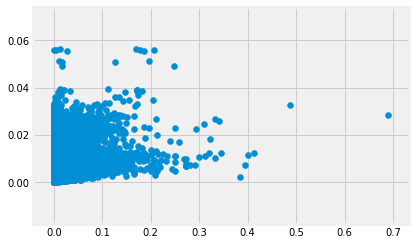

In [89]:
plt.scatter(y_test, y_pred)
plt.show()

In [102]:
max(y_test)

0.68896484375

In [103]:
max(y_pred)

0.0562350808385597

In [99]:
pd.Series(y_pred)[0:1000]


0      0.001522
1      0.001499
2      0.001489
3      0.001516
4      0.001572
         ...   
995    0.002478
996    0.002478
997    0.002516
998    0.002506
999    0.002440
Length: 1000, dtype: float64

In [ ]:
# jeu de validation 

In [66]:
df_validation

,snap_CA,snap_TX,snap_WI,sell_price,agg_sales_store_dept,product_share,dow,dom,month,week,...,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3
1017,0,0,0,8.38,0.0,NaN,0,25,4,17,...,1,0,0,0,0,0,0,0,0,0
1018,0,0,0,8.38,0.0,NaN,1,26,4,17,...,1,0,0,0,0,0,0,0,0,0
1019,0,0,0,8.38,0.0,NaN,2,27,4,17,...,1,0,0,0,0,0,0,0,0,0
1020,0,0,0,8.38,0.0,NaN,3,28,4,17,...,1,0,0,0,0,0,0,0,0,0
1021,0,0,0,8.38,0.0,NaN,4,29,4,17,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46881672,0,0,0,1.00,0.0,NaN,2,18,5,20,...,0,0,0,0,0,0,0,0,0,1
46881673,0,0,0,1.00,0.0,NaN,3,19,5,20,...,0,0,0,0,0,0,0,0,0,1
46881674,0,0,0,1.00,0.0,NaN,4,20,5,20,...,0,0,0,0,0,0,0,0,0,1
46881675,0,0,0,1.00,0.0,NaN,5,21,5,20,...,0,0,0,0,0,0,0,0,0,1


In [72]:
df_validation['product_share'].count()

0

In [73]:
df_validation.drop(columns=['product_share'], inplace=True) 

In [74]:
y_valid = model.predict(df_validation)

In [75]:
df_validation['product_share']=y_valid

In [91]:
df_validation['product_share']

1017        0.000016
1018        0.000016
1019        0.000016
1020        0.000016
1021        0.000016
              ...   
46881672    0.000059
46881673    0.000059
46881674    0.000060
46881675    0.000060
46881676    0.000060
Name: product_share, Length: 853720, dtype: float64

In [0]:
#predict sur le jeu de test 

In [0]:
prediction = np.rint(model.predict(df_test, num_iteration=model.best_iteration))
error = mean_squared_error(y_test, prediction)

In [0]:
best_params = model.params
print("Best params:", best_params)
print("  RMSE = {}".format(error))
print("  Params: ")
for key, value in best_params.items():
  print("    {}: {}".format(key, value))

In [0]:
print(‘Best Params:’, best_params)
print(‘Tuning history:’, tuning_history)